## Load the required packages

In [1]:
require (ROCR);
require(caret)
require(randomForest)
require(e1071)
require(pROC)

Loading required package: ROCR
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Loading required package: caret
Loading required package: lattice
Loading required package: ggplot2
Loading required package: randomForest
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: e1071
Loading required package: pROC
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var



## Load the dataset

In [2]:
tab <- read.table("credit.data", dec = ".", sep=",", header = F)

## Convert categorical data into one-hot encoded columns

In [3]:
dummyTab <- dummyVars("~V1 + V4 + V5 + V6 + V7 + V13", data = tab)
dummyTab <- data.frame(predict(dummyTab, newdata = tab))
dummyTab <- dummyTab[, !names(dummyTab) %in% c("V1..", "V4..", "V5..", "V6..", "V7..", "V13..")]
tab <- cbind(tab,dummyTab)
tab$V9 <- as.numeric(tab$V9)-1
tab$V10 <- as.numeric(tab$V10)-1
tab$V12 <- as.numeric(tab$V12)-1
tab$V16 <- as.numeric(tab$V16)-1
tab$V16 <- as.factor(tab$V16)
tab$V2 <- as.numeric(as.matrix(tab$V2))
tab$V14 <- as.numeric(as.matrix(tab$V14))
tab <- tab[,!names(tab) %in% c("V1", "V4", "V5", "V6", "V7", "V13")]
tab[is.na(tab)] <- 0

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

# Random Forest Classifier

## Grid search through RandomForest parameters to record ones that give highest AUC Score
* `ntree = [1000]` - number of trees to consider
* `mtry = [sq.root(n_feat)/2, sq.root(n_feat), 2*sq.root(n_feat)]` - number of features considered choosing best plit
* `cutoff = ([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], [1-cutoff])` - percentage of trees that need to vote for True to classify True

In [4]:
auc_best = 0.0
n_feat = length(tab) - 1
best = c(0,0,0)
ntree = 1000
    for (mtry in c(as.integer(sqrt(n_feat)/2), as.integer(sqrt(n_feat)), as.integer(sqrt(n_feat)*2))){
        for (cutoff in c(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9)){
            rfc <- randomForest(V16~., data=tab, cutoff = c(cutoff, 1-cutoff), ntree=ntree, mtry=mtry)
            recall <- rfc$confusion[4]/(rfc$confusion[3] + rfc$confusion[4])
            precision <- rfc$confusion[4]/(rfc$confusion[4] + rfc$confusion[2])
            rfc.roc <- roc(tab$V16, rfc$votes[,2])
            auc_score <- auc(rfc.roc)
            if (auc_score > auc_best){
                auc_best = auc_score
                best = c(ntree,mtry,cutoff)
            }
            }
        }




In [5]:
out <- sprintf("Best AUC_Score settings: \n \n Ntree: %4d \n Mtry: %2d \n Cutoff: %1.2f \n AUCScore: %1.4f",best[1], best[2], best[3], auc_best)
cat(out)

Best AUC_Score settings: 
 
 Ntree: 1000 
 Mtry:  6 
 Cutoff: 0.70 
 AUCScore: 0.9333

### Train the classifier with best parameters

In [6]:
rfc <- randomForest(V16~., data=tab, cutoff = c(best[3], 1-best[3]), ntree=best[1], mtry=best[2], importance = TRUE)

### Plot AUC result

[1] "AUC Score: 0.9298"


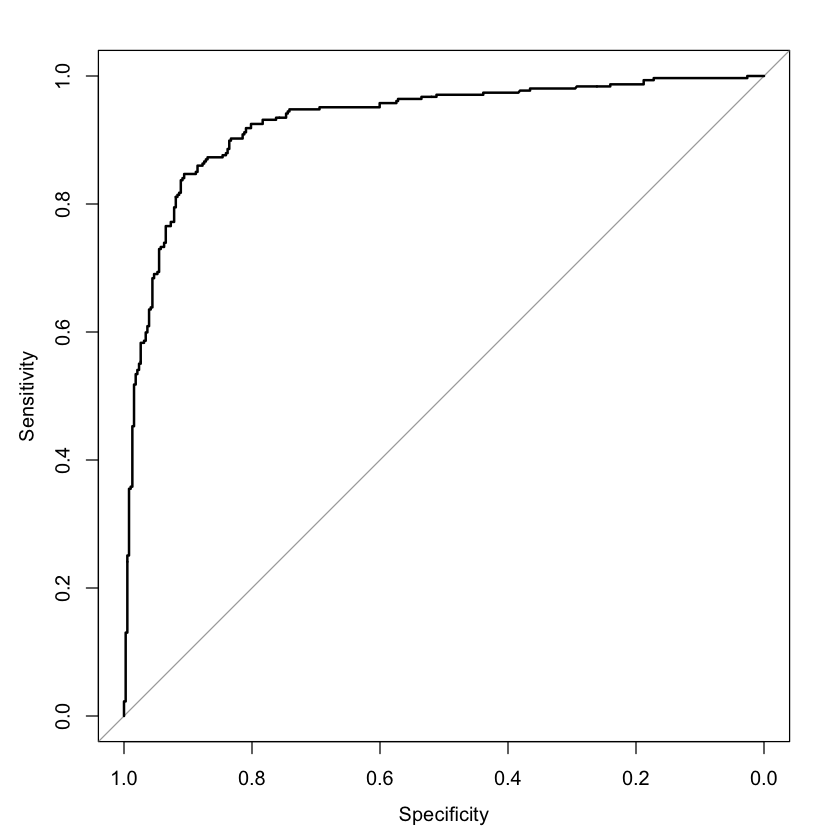

In [7]:
rfc.roc <- roc(tab$V16, rfc$votes[,2])
plot(rfc.roc)
rfc.auc_score <- auc(rfc.roc)
out <- sprintf("AUC Score: %1.4f", rfc.auc_score)
print(out )

# Support Vector Classifier

In [8]:
set.seed(1000)

## Normalize the data with 0 mean and unit variance

In [9]:
tab_norm <- tab
tab_norm[colnames(tab_norm) != "V16"] <- scale(tab_norm[colnames(tab_norm) != "V16"], center = TRUE, scale = FALSE)

## Split the data set into *train* and *test* sections to determine AUC Score

In [10]:
n <- nrow(tab_norm)
shuffled_tab <- tab_norm[sample(n), ]
train_indices <- 1:round(0.75 * n)
train_norm <- shuffled_tab[train_indices, ]
test_indices <- (round(0.75 * n) + 1):n
test_norm <- shuffled_tab[test_indices, ]

## Create functions for measuring accuracy

In [11]:
F1_Score <- function (classifier, data, labels){
    pred <- predict(classifier,data)
    recall <- table(pred, labels)[4]/(table(pred, labels)[3]+table(pred, labels)[4])
    precision <- table(pred, labels)[4]/(table(pred, labels)[4]+table(pred, labels)[2])
    f1_score <- 2*precision*recall/(precision + recall)
    f1_score
    }

AUC_Score <- function(classifier, data,labels){
    pred <- predict(classifier,data, probability = TRUE)
    pred.prob <- attr(pred, "prob")[,1]
    svc.roc <- roc(labels, pred.prob)
    auc(svc.roc)
}

## Grid Search through SVM parameter values to determine ones with best AUC Score
`C = [0.001, 0.002154435, 0.004641589, 0.01, 0.021544,0.03125,  0.06250,  0.12500,  0.25000,  0.50000,  1.00000,  2.00000,  4.00000,8.00000, 16.00000, 32.00000]` - Cost of misclassification

In [12]:
bestSvc = c(0)
auc_best_svc = 0.0
for(C in c(0.001, 0.002154435, 0.004641589, 0.01, 0.021544,0.03125,  0.06250,  0.12500,  0.25000,  0.50000,  1.00000,  2.00000,  4.00000,
8.00000, 16.00000, 32.00000)) {
    
    svc <- svm(V16~.,data=train_norm,kernel='linear',cost=C, probability = TRUE)  
    auc_score <- AUC_Score(svc, test_norm, test_norm$V16)
    if (auc_score > auc_best_svc){
        auc_best_svc = auc_score
        bestSvc = c(C)
    }
}

In [13]:
out <- sprintf("Best F1_Score settings:\n \nC: %2.4f \nAUCScore: %1.4f", bestSvc[1], auc_best_svc)
cat(out)

Best F1_Score settings:
 
C: 0.0022 
AUCScore: 0.9077

## Train the classifier with best parameters

In [14]:
svc <- svm(V16~.,data=train_norm,kernel='linear',cost=bestSvc[1], probability = TRUE)

In [15]:
pred <- predict(svc,test_norm, probability = TRUE)
pred.prob <- attr(pred, "prob")[,1]

AUC Score: 0.9077

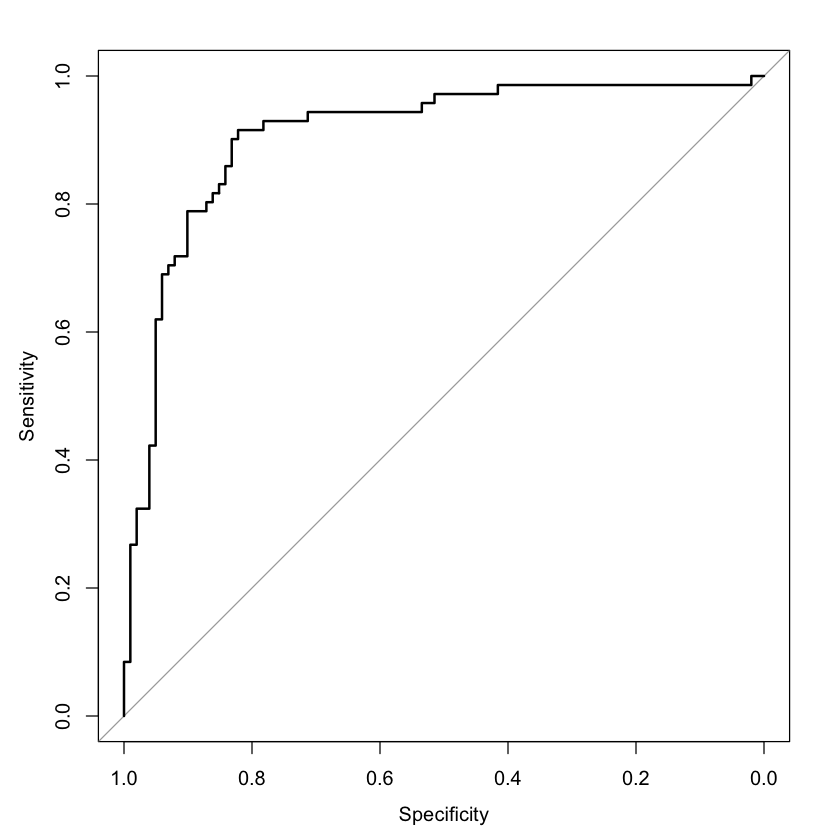

In [16]:
svc.roc <- roc(test_norm$V16, pred.prob)
plot(svc.roc)
svc.auc_score <- auc(svc.roc)
out <- sprintf("AUC Score: %1.4f", svc.auc_score)
cat(out)

# Feature Ranking

### Random Forest: MDA+ and MDA- 

In [17]:
var.importance <- importance(rfc, type = 1)
var.importance <- cbind(var.importance, importance(rfc, type = 1))
print("RandomForest variable importances using importance from randomForest package (MDA-) and (MDA+) ordered by MDA+")
var.importance[order(var.importance[,1], decreasing=TRUE), , drop=FALSE]

[1] "RandomForest variable importances using importance from randomForest package (MDA-) and (MDA+) ordered by MDA+"


,MeanDecreaseAccuracy,MeanDecreaseAccuracy
V9,74.0602954,74.0602954
V11,26.8608822,26.8608822
V15,24.6496436,24.6496436
V8,22.1131278,22.1131278
V10,20.1488712,20.1488712
V6.x,14.1956795,14.1956795
V6.ff,12.8964601,12.8964601
V14,12.4921270,12.4921270
V7.ff,11.9990938,11.9990938
V5.p,10.0339222,10.0339222


## Support Vector Machine: |Wj|

In [18]:
w <- t(svc$coefs) %*% svc$SV
w <- abs(w)
w <- t(w)
w <- w[order(w, decreasing=TRUE), , drop=FALSE]
print("SVM feature importances using absoluto values of respective weights")
w

[1] "SVM feature importances using absoluto values of respective weights"


V9,4.911014e-01
V10,1.898003e-01
V11,1.474649e-01
V8,1.002963e-01
V6.x,9.423493e-02
V15,7.868133e-02
V6.ff,6.838287e-02
V2,6.334134e-02
V6.q,5.530641e-02
V7.ff,5.481606e-02
V14,5.382585e-02


## Train new models with 1/2 of most important features

In [26]:
new_rfc <- randomForest(V16~., data=tab[c(rownames(head(var.importance, as.integer(n_feat/2))), "V16")], cutoff = c(best[3], 1-best[3]), ntree=best[1], mtry=best[2])

In [27]:
new_svc <- svm(V16~.,data=train_norm[c(rownames(head(w, as.integer(n_feat/2))), "V16")],kernel='linear',cost=bestSvc[1], probability = TRUE)

## Test new models' accuracy

In [28]:
new_svc.auc_score <- AUC_Score(new_svc, test_norm[rownames(head(w, as.integer(n_feat/2)))], test_norm$V16)
new_rfc.roc <- roc(tab$V16, new_rfc$votes[,2])
new_rfc.auc_score <- auc(new_rfc.roc)
out <- sprintf("New RF Classifier AUC Score: %1.4f \nNew SV Classifier AUC Score: %1.4f", new_rfc.auc_score, new_svc.auc_score)
cat(out)

New RF Classifier AUC Score: 0.9300 
New SV Classifier AUC Score: 0.9049

### Plotting of data with respect to some of the top important features
* Small green - False Positive
* Large green - True Positive
* Small red - True Negative
* Large red - False Negative



### RFC results

Warning message:
“Using size for a discrete variable is not advised.”

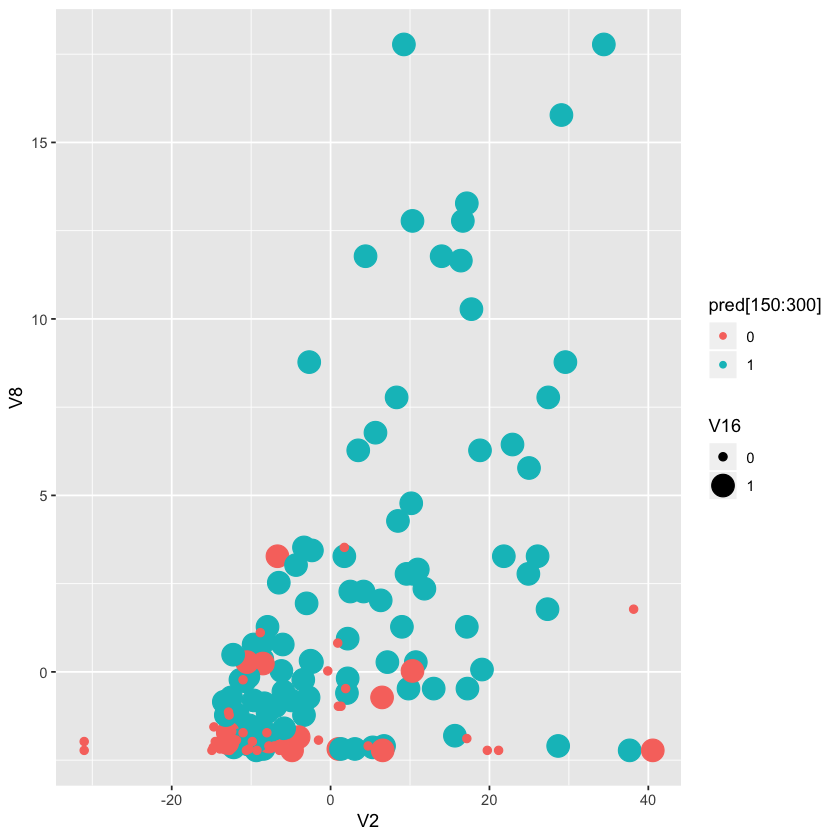

In [22]:
pred <- predict(svc, tab_norm)
ggplot(data=tab_norm[150:300,]) + 
  geom_point(mapping = aes(x = V2, y = V8, color = pred[150:300], size = V16))

### SVC results

Warning message:
“Using size for a discrete variable is not advised.”

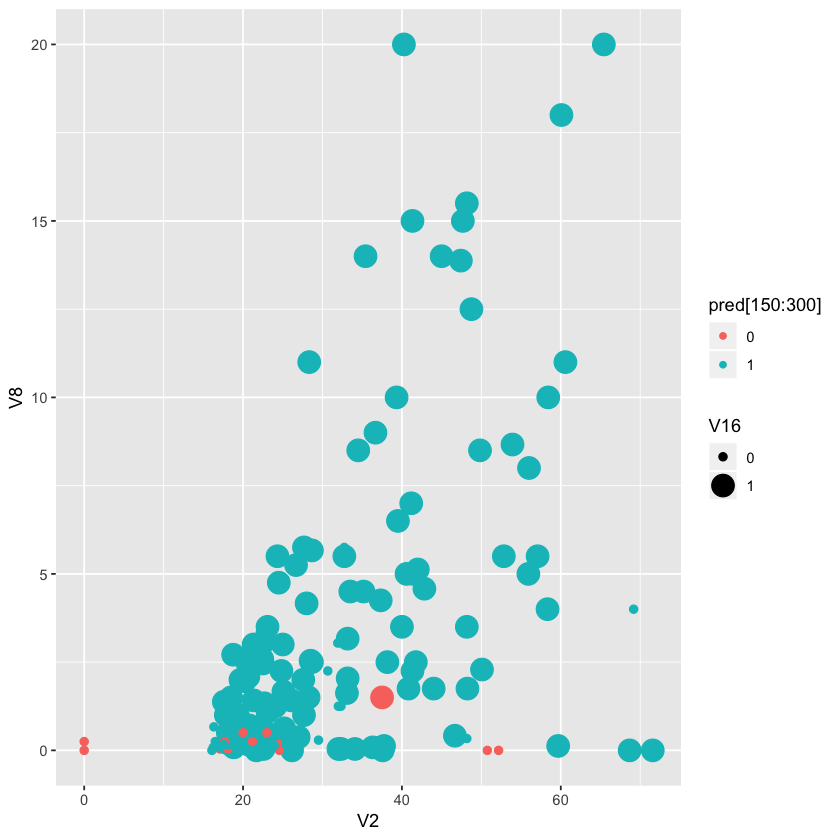

In [23]:
pred <- predict(svc,tab, probability = TRUE)
ggplot(data=tab[150:300,]) + 
  geom_point(mapping = aes(x = V2, y = V8, color = pred[150:300], size = V16))